In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 读入数据
data = pd.read_csv('./data/airline-passengers.csv',parse_dates=[0])
data

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:
import datetime 
def convertTime(t):
    d = t.date()
    return pd.Series({"year":d.year,"month":d.month})
data =data.merge(data['Month'].apply(convertTime), left_index=True, right_index=True)
data.head()

,Month,Passengers,year,month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


In [4]:
# 进行正则化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data = data[['Passengers','year','month']]
data = sc.fit_transform(data) # 拟合并转换
print(data.shape)

(144, 3)


In [5]:
# Create Training and Test
train_size= int(len(data)*0.85)
test_size= len(data) -train_size
train = data[:train_size]
test = data[train_size:]

In [6]:
# 滑动窗口，构造训练集x和y
def sliding_windows(data, seq_length):
    x = []
    y = []
    weight_num=0
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length][:1] # 目标值只有第一个字段
        x.append(_x)
        y.append(_y)
        
    return np.array(x),np.array(y)

seq_length = 8  # 获取15预测
x, y = sliding_windows(train, seq_length) # 按滑动窗口，4个时间，预测一个未来
print(x.shape,y.shape) # (set_num,seq_len,input_dim)

(114, 8, 3) (114, 1)


In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        # 此处batch_first=True，
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)) #num_layers * num_directions, batch, hidden_size
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, c_out) = self.lstm(x, (h_0, c_0)) 
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out
    
    
num_epochs = 2000
learning_rate = 0.01
print('x.shape=',x.shape)
input_size = x.shape[2] ## 编写x的shape
hidden_size = input_size*2 ## 隐藏为输入维度的2倍
num_layers = 1

num_classes = 1 # 输出维度

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression  MSE
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
_index= list(range(x.shape[0]))

# Train the model
for epoch in range(num_epochs):
    i = 0
    batch_size = 200 
    random.shuffle(_index)
    while i < len(x):
        start = i
        i = min(i+batch_size,len(x))
        trainX = torch.Tensor(x[_index[start:i]])
        trainY = torch.Tensor(y[_index[start:i]])
        outputs = lstm(trainX) # 训练集
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 1:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

x.shape= (114, 8, 3)
Epoch: 1, loss: 0.20973
Epoch: 101, loss: 0.00446
Epoch: 201, loss: 0.00257
Epoch: 301, loss: 0.00175
Epoch: 401, loss: 0.00105
Epoch: 501, loss: 0.00066
Epoch: 601, loss: 0.00048
Epoch: 701, loss: 0.00040
Epoch: 801, loss: 0.00035
Epoch: 901, loss: 0.00031
Epoch: 1001, loss: 0.00028
Epoch: 1101, loss: 0.00025
Epoch: 1201, loss: 0.00023
Epoch: 1301, loss: 0.00021
Epoch: 1401, loss: 0.00019
Epoch: 1501, loss: 0.00018
Epoch: 1601, loss: 0.00018
Epoch: 1701, loss: 0.00017
Epoch: 1801, loss: 0.00016
Epoch: 1901, loss: 0.00016


In [8]:

pred_data = data.copy()
# 进行预测
for i in range(train_size,len(pred_data)):
    _var_x = pred_data[i-seq_length:i]  # 取seq_len作为输入序列
    var_x =  torch.Tensor(_var_x[np.newaxis,:,:]) 
#     print(var_x.shape)
    outputs = lstm(var_x) # 训练集
#     print(outputs[-1][0],test_x[i+seq_len, 0])
    pred_data[i, 0] =  outputs[0][0]
#     print(test_x[i+seq_len, 0])
    

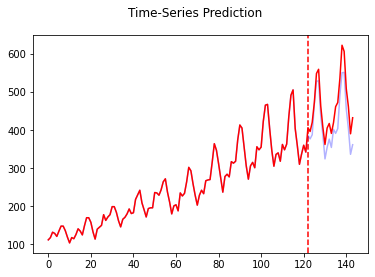

In [9]:
y_real = sc.inverse_transform(data)[:,0]
y_predict = sc.inverse_transform(pred_data)[:,0]
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(y_predict,'b', label='real', alpha=0.3)
plt.plot(y_real, 'r', label='pred') 
plt.suptitle('Time-Series Prediction')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error 
mse = mean_squared_error(y_real[train_size:],y_predict[train_size:])
print('mse=',mse)

mse= 2059.815775233092
